In [5]:
import os, sys; sys.path.append('../utils')
import pandas as pd
import numpy as np

import torch
import torch_geometric as pyg
from torch_geometric.nn import SAGEConv, GCNConv, GATConv, Sequential, global_max_pool, global_mean_pool, BatchNorm
from torch_geometric.nn import SAGPooling, Set2Set, GlobalAttention

from graph_prep import GraphDataset
from train_graphs import get_vector, make_like_batch, train, CV_eval

data = pd.read_csv(os.path.join('/home/sai/Eastman_Project/CombinedData', 
            'combined_data_clean.csv'))

mw_vector = get_vector(data, prop = 'Mw (PS)').to_numpy()
an_vector = get_vector(data, prop = 'AN').to_numpy()
ohn_vector = get_vector(data, prop = 'OHN').to_numpy()
tmp_vector = get_vector(data, prop = '%TMP', fill_value=0).to_numpy()

add = np.stack([mw_vector, an_vector, ohn_vector, tmp_vector]).T

dataset = GraphDataset(data = data, Y_target=['IV'], test_size = 0.15, add_features = add)

In [19]:
def make_model(output_layer_list):
    class GNNSophPool(torch.nn.Module):
        def __init__(self, input_feat, hidden_channels, num_additional = 0):
            super(GNNSophPool, self).__init__()
            self.hidden_channels = hidden_channels

            self.Asage = Sequential('x, edge_index, batch', [
                (GATConv(input_feat, hidden_channels, aggr = 'max'), 'x, edge_index -> x'),
                BatchNorm(hidden_channels, track_running_stats=False),
                torch.nn.PReLU(),
                (SAGEConv(hidden_channels, hidden_channels, aggr = 'max'), 'x, edge_index -> x'),
                BatchNorm(hidden_channels, track_running_stats=False),
                torch.nn.PReLU(),
                (SAGPooling(hidden_channels), 'x, edge_index, batch=batch -> x'),
            ])

            self.Gsage = Sequential('x, edge_index, batch', [
                (GATConv(input_feat, hidden_channels, aggr = 'max'), 'x, edge_index -> x'),
                BatchNorm(hidden_channels, track_running_stats=False),
                torch.nn.PReLU(),
                (SAGEConv(hidden_channels, hidden_channels, aggr = 'max'), 'x, edge_index -> x'),
                BatchNorm(hidden_channels, track_running_stats=False),
                torch.nn.PReLU(),
                (SAGPooling(hidden_channels), 'x, edge_index, batch=batch -> x'),
            ])
            self.linears = torch.nn.ModuleList()
            for i in range(len(output_layer_list)):
                    self.linears.append(torch.nn.Linear(output_layer_list[i][0], output_layer_list[i][1]))
                    self.linears.append(torch.nn.PReLU())
                
            #self.leaky_out = torch.nn.PReLU()
            self.out = torch.nn.Linear(output_layer_list[len(output_layer_list)-1][1], 1)

            #self.fc1 = torch.nn.Linear(hidden_channels * 2 + num_additional, hidden_channels)

        def forward(self, Abatch: torch.Tensor, Gbatch: torch.Tensor, add_features: torch.Tensor):
            '''
            
            '''
            # Decompose X into acid and glycol

            Aembeddings = self.Asage(Abatch.x, Abatch.edge_index, Abatch.batch)[0]
            Gembeddings = self.Gsage(Gbatch.x, Gbatch.edge_index, Gbatch.batch)[0]
            
            Aembed, _ = torch.max(Aembeddings, dim=0)
            Gembed, _ = torch.max(Gembeddings, dim=0)

            # Aggregate pooled vectors
            if add_features is not None:
                x = torch.cat([Aembed, Gembed, add_features])
            else:
                x = torch.cat([Aembed, Gembed])

            for i in range(len(self.linears)):
                x = self.linears[i](x)

            x = self.out(x)

            # Because we're predicting log:
            return torch.exp(x)
    return GNNSophPool

In [ ]:
model_generator_kwargs = {
    'input_feat': 7,
    'hidden_channels': 32,
    'num_additional': 4,
}

model_tmp = make_model([
    (model_generator_kwargs['hidden_channels'] * 2 + model_generator_kwargs['num_additional'], model_generator_kwargs['hidden_channels']),
    ])

optimizer_gen = torch.optim.Adam
criterion = torch.nn.MSELoss()

all_predictions, all_y, all_inds = CV_eval(
    dataset = dataset,
    model_generator = model_tmp,
    optimizer_generator = optimizer_gen,
    criterion = criterion,
    model_generator_kwargs = model_generator_kwargs,
    optimizer_kwargs = {'lr': 0.0001, 'weight_decay':1e-4},
    epochs = 800,
    batch_size = 64,
    verbose = 1,
    )

In [ ]:
model_generator_kwargs = {
    'input_feat': 7,
    'hidden_channels': 32,
    'num_additional': 4,
}

model_tmp = make_model([
    (model_generator_kwargs['hidden_channels'] * 2 + model_generator_kwargs['num_additional'], model_generator_kwargs['hidden_channels']),
    (model_generator_kwargs['hidden_channels'], model_generator_kwargs['hidden_channels']),
    ])

optimizer_gen = torch.optim.Adam
criterion = torch.nn.MSELoss()

all_predictions, all_y, all_inds = CV_eval(
    dataset = dataset,
    model_generator = model_tmp,
    optimizer_generator = optimizer_gen,
    criterion = criterion,
    model_generator_kwargs = model_generator_kwargs,
    optimizer_kwargs = {'lr': 0.0001, 'weight_decay':1e-4},
    epochs = 800,
    batch_size = 64,
    verbose = 1,
    )

In [20]:
model_generator_kwargs = {
    'input_feat': 7,
    'hidden_channels': 32,
    'num_additional': 4,
}

model_tmp = make_model([
    (model_generator_kwargs['hidden_channels'] * 2 + model_generator_kwargs['num_additional'], model_generator_kwargs['hidden_channels']),
    (model_generator_kwargs['hidden_channels'], model_generator_kwargs['hidden_channels']),
    (model_generator_kwargs['hidden_channels'], model_generator_kwargs['hidden_channels']),
    ])

optimizer_gen = torch.optim.Adam
criterion = torch.nn.MSELoss()

all_predictions, all_y, all_inds = CV_eval(
    dataset = dataset,
    model_generator = model_tmp,
    optimizer_generator = optimizer_gen,
    criterion = criterion,
    model_generator_kwargs = model_generator_kwargs,
    optimizer_kwargs = {'lr': 0.0001, 'weight_decay':1e-4},
    epochs = 800,
    batch_size = 64,
    verbose = 1,
    )

Fold: 1 	 Epoch: 0, 	 Train r2: -4.3198 	 Train Loss: 15.8682


KeyboardInterrupt: 

In [ ]:
model_generator_kwargs = {
    'input_feat': 7,
    'hidden_channels': 32,
    'num_additional': 4,
}

model_tmp = make_model([
    (model_generator_kwargs['hidden_channels'] * 2 + model_generator_kwargs['num_additional'], model_generator_kwargs['hidden_channels']),
    (model_generator_kwargs['hidden_channels'], model_generator_kwargs['hidden_channels']),
    (model_generator_kwargs['hidden_channels'], model_generator_kwargs['hidden_channels']),
    (model_generator_kwargs['hidden_channels'], model_generator_kwargs['hidden_channels']),
    ])

optimizer_gen = torch.optim.Adam
criterion = torch.nn.MSELoss()

all_predictions, all_y, all_inds = CV_eval(
    dataset = dataset,
    model_generator = model_tmp,
    optimizer_generator = optimizer_gen,
    criterion = criterion,
    model_generator_kwargs = model_generator_kwargs,
    optimizer_kwargs = {'lr': 0.0001, 'weight_decay':1e-4},
    epochs = 800,
    batch_size = 64,
    verbose = 1,
    )

In [8]:
# Identify outliers:

all_predictions = np.array(all_predictions)
all_y = np.array(all_y)
all_inds = np.array(all_inds)

error_vec = np.abs(all_predictions - all_y)
most_errors = np.argsort(error_vec)

print('5 largest errors:', error_vec[most_errors][-5:])

# Sort by args:
inds = all_inds[most_errors]

data_trim = data.loc[data['IV'].notna(),:]

df_err = data_trim.iloc[inds[-5:],:].copy()

df_err['Abs_error'] = error_vec[most_errors][-5:]

df_err.to_csv('error5_iv.csv', index = False)

print('Largest')
print('Indices:', inds[-5:])
print(df_err)

# print(all_y)
# print(dataset.Y)

#errors = [all_y[i] - dataset.Y[all_inds[i]] for i in range(len(all_y))]
#print(errors)

5 largest errors: [0.28402245 0.39377677 0.41667312 0.4307279  0.96686405]
Largest
Indices: [135 223 215 161 275]
       Resin# Reactor Reaction Solvent    AN        OHN OHN (primary)  \
185       186     Rig             Neat  1.48  16.931946           NaN   
279        C2     NaN              NaN   NaN        NaN           NaN   
269  Resin 6d     Rig             Neat  2.50  16.820000           NaN   
211       213     Rig             Neat  2.67  11.570767           NaN   
331       C54     NaN              NaN   NaN        NaN           NaN   

    OHN (secondary)     IV  IV - Intrinsic     Tg  ...  %NPG  %1,4-CHDM  \
185             NaN  0.608           0.634    NaN  ...   NaN       57.6   
279             NaN  0.840             NaN  45.00  ...   NaN        NaN   
269             NaN  1.091           1.181  37.97  ...   NaN       38.7   
211             NaN  0.823           0.872    NaN  ...   NaN       43.1   
331             NaN  1.600             NaN  -3.00  ...   NaN        NaN 

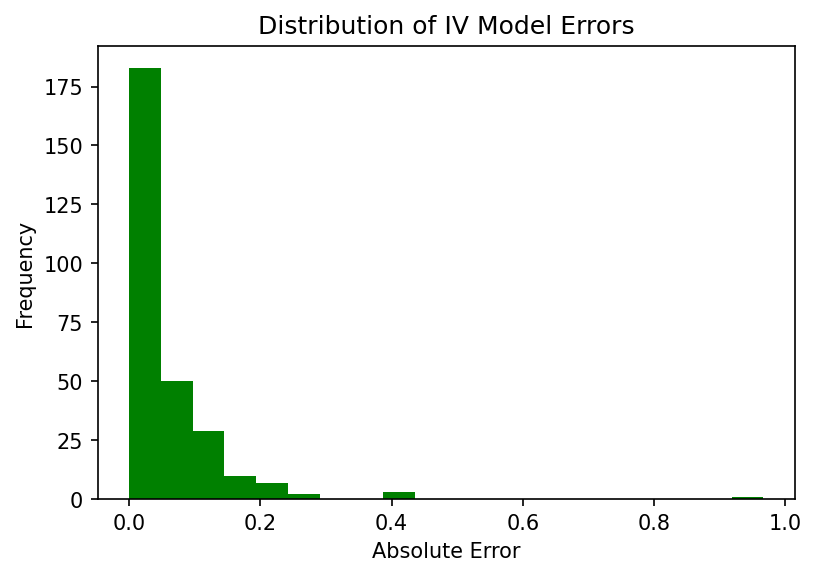

In [9]:
import matplotlib.pyplot as plt

error = np.abs(np.array(all_predictions) - np.array(all_y))
error = np.sort(error)

plt.figure(dpi=150)
plt.hist(error, bins = 20, color = 'green')
plt.title('Distribution of IV Model Errors')
plt.xlabel('Absolute Error')
plt.ylabel('Frequency')
plt.show()

Number over 0.3, 4


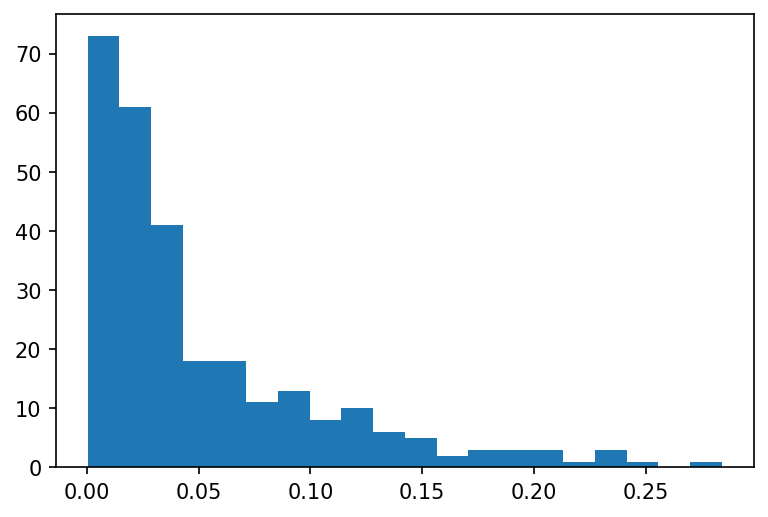

In [10]:
# Find samples with largest error:
mask = (error < 0.3)
masked_error = error[mask]

print('Number over 0.3, {}'.format(np.sum((error > 0.3))))

plt.figure(dpi=150)
plt.hist(masked_error, bins = 20)
plt.show()

In [11]:
masky = np.array(all_y)[mask]
maskpred = np.array(all_predictions)[mask]

print(r2_score(masky, maskpred))

NameError: name 'r2_score' is not defined

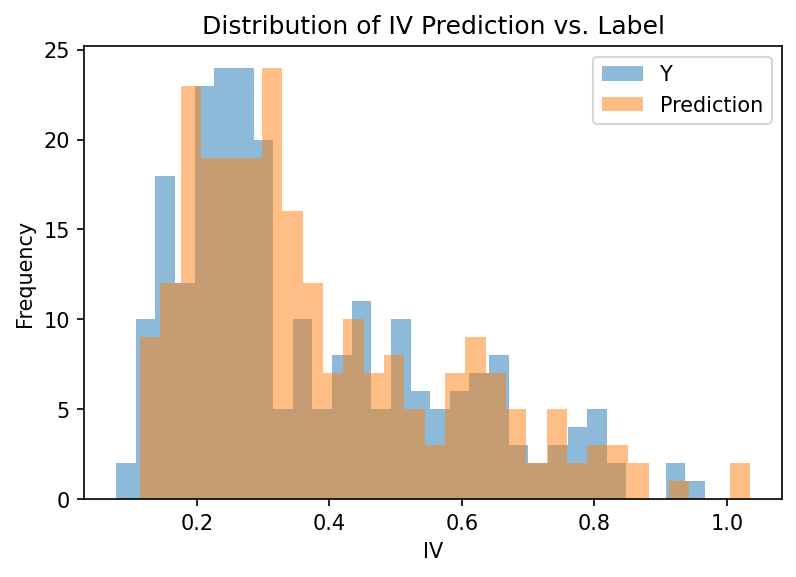

In [ ]:
plt.figure(dpi=150)
plt.hist(all_y, alpha = 0.5, bins = 30, label = 'Y')
plt.hist(all_predictions, alpha = 0.5, bins = 30, label = 'Prediction')
plt.legend()
plt.title('Distribution of IV Prediction vs. Label')
plt.xlabel('IV')
plt.ylabel('Frequency')
plt.show()

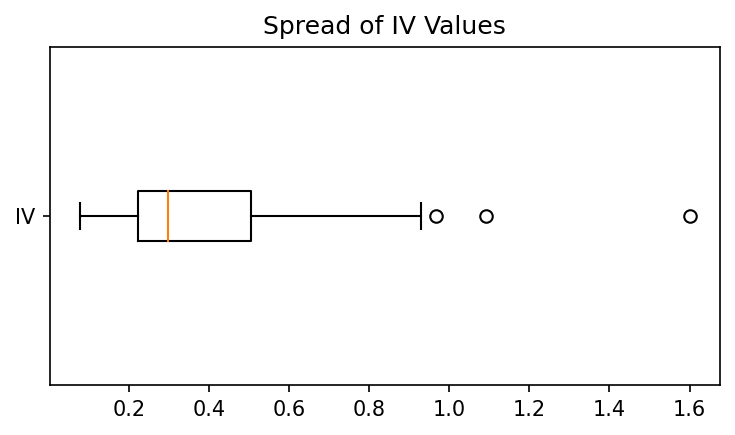

In [ ]:
plt.figure(dpi=150, figsize = [5, 3])
plt.boxplot(all_y, vert = False)
plt.yticks(ticks = [1], labels = ['IV'])
plt.title('Spread of IV Values')
plt.tight_layout()
plt.show()

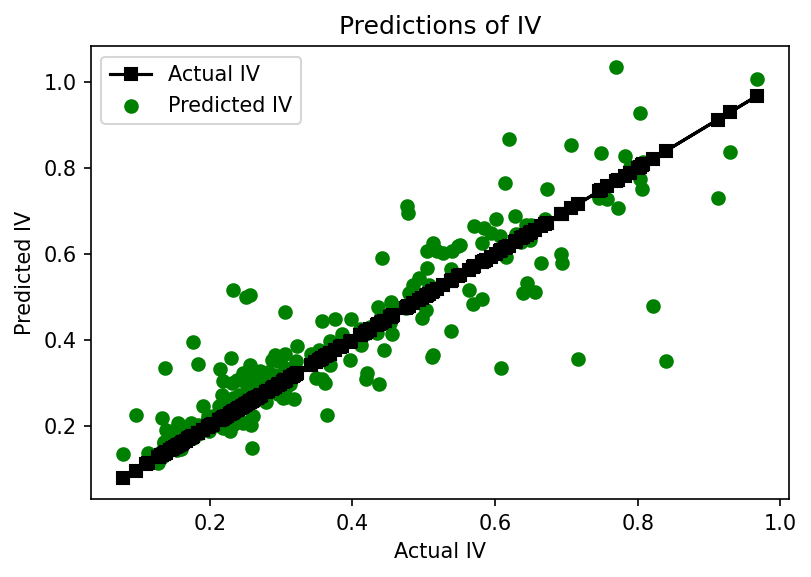

In [ ]:
# Predicted vs. Actual plot
plt.figure(dpi=150)
plt.plot(all_y, all_y, marker = 's', c = 'black', label = 'Actual IV')
plt.scatter(all_y, all_predictions, c = 'green', label = 'Predicted IV')
plt.xlabel('Actual IV')
plt.ylabel('Predicted IV')
plt.title('Predictions of IV')
plt.legend()
plt.show()